Ordinary Differential Equations: Conversion Reaction
============================

This example provides a model for the interconversion of two species 
($X_1$ and $X_2$) following first-order mass action kinetics with the 
parameters $\Theta_1$ and $\Theta_2$ respectively:


$$
    X_1 \rightarrow X_2, rate = \Theta_1 \cdot [X_1]
$$

$$
    X_2 \rightarrow X_1, rate = \Theta_2 \cdot [X_2]
$$

Measurement of $[X_2]$ is provided as $Y = [X_2]$.

We will show how to estimate $\Theta_1$ and $\Theta_2$ using pyABC.

In [29]:
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tempfile
import scipy as sp
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

Data
----

We use an artificial data set which consists of a vector of time points $t$
and a measurement vector $Y$. This data was created using the parameter 
values which are assigned to $\Theta_{true}$ and by adding normaly distributed 
measurement noise with variance $\sigma^2 = 0.015^2$. 

ODE model
---------

$$
    \begin{align*}
    \frac{dX_1}{dt} &= -\Theta_1 \cdot X_1 + \Theta_2 \cdot X_2\\
    \frac{dX_2}{dt} &= \Theta_1 \cdot X_1 - \Theta_2 \cdot X_2
    \end{align*}
$$

Define the true parameters

In [30]:
theta1_true, theta2_true = sp.exp([-2.5, -2])

and the measurement data

In [31]:
measurement_data = sp.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])

as well as the time points at whith to evaluate

In [32]:
measurement_times = sp.arange(len(measurement_data))        

and the initial conditions for $X_1$ and $X_2$

In [33]:
init = sp.array([1, 0])

Define the ODE model

In [34]:
def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2


def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],pars["theta2"]))
    return {"X_2": sol[:,1]}

Integration of the ODE model for the true parameter values

In [35]:
true_trajectory = model({"theta1": theta1_true,
                         "theta2": theta2_true})["X_2"]

Let's visualize the results

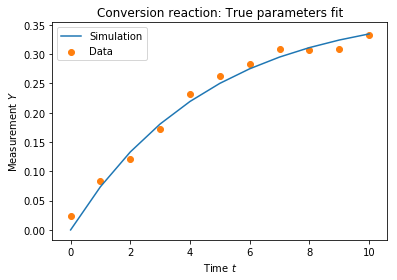

In [36]:
plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data,
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In [37]:
def distance(simulation, data):
    return sp.absolute(data["X_2"] - simulation["X_2"]).sum()

Define the prior for $\Theta_1$ and $\Theta_2$

In [38]:
parameter_prior = Distribution(theta1=RV("uniform", 0, 1),
                               theta2=RV("uniform", 0, 1))
parameter_prior.get_parameter_names()

['theta1', 'theta2']

In [39]:
abc = ABCSMC(models=model,
             parameter_priors=parameter_prior,
             distance_function=distance,
             population_size=50,
             transitions=LocalTransition(k_fraction=.3),
             eps=MedianEpsilon(500, median_multiplier=0.7))

In [40]:
abc.new(db_path, {"X_2": measurement_data});

INFO:Epsilon:initial epsilon is 500
INFO:History:Start <ABCSMC(id=15, start_time=2018-04-08 14:12:39.190429, end_time=None)>


In [41]:
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:ABC:t:0 eps:500
INFO:ABC:t:1 eps:1.7534597722763574
INFO:ABC:t:2 eps:0.7020740722996631
INFO:ABC:t:3 eps:0.38017826165880875
INFO:ABC:t:4 eps:0.24558135952196075
INFO:History:Done <ABCSMC(id=15, start_time=2018-04-08 14:12:39.190429, end_time=2018-04-08 14:13:04.672024)>


Visualization of the probability density functions for $\Theta_1$ and $\Theta_2$

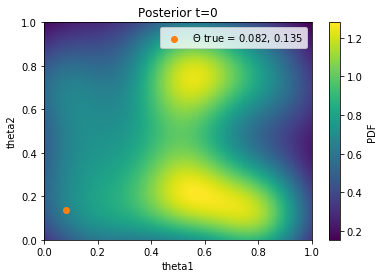

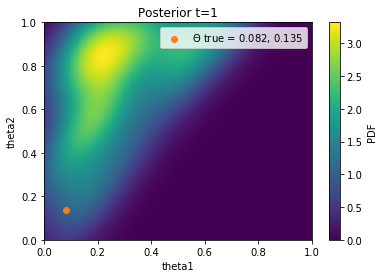

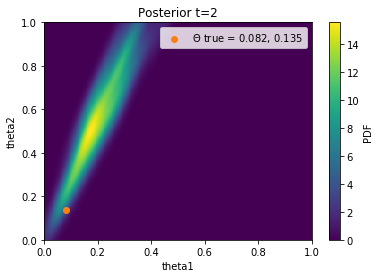

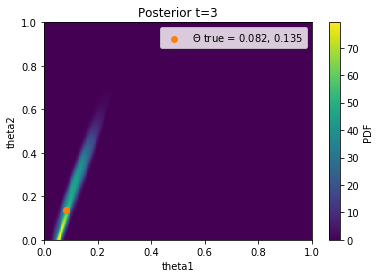

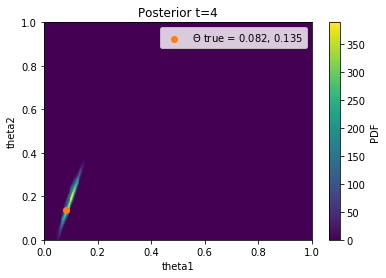

In [42]:
for t in range(h.max_t+1):
    ax = plot_kde_2d(*h.get_distribution(m=0, t=t),
                     "theta1", "theta2",
                xmin=0, xmax=1, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.scatter([theta1_true], [theta2_true],
                color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    theta1_true, theta2_true))
    ax.set_title("Posterior t={}".format(t))
    ax.legend()